In [1]:
from datetime import datetime as dt
import numpy as np
import torch

from matplotlib import pyplot as plt
from torch.utils.data import random_split

from preconditioners import settings
from preconditioners.datasets import generate_true_parameter, CenteredLinearGaussianDataset, generate_true_parameter, generate_c
from preconditioners.utils import MLP, SLP
from preconditioners.optimizers import PrecondGD
import preconditioners
import multiprocessing, threading


In [2]:
# Same as in linear_kernel_variance_30102022.ipynb (and if it is not, it should be)

from preconditioners.datasets import generate_c, generate_centered_linear_gaussian_data, generate_true_parameter, generate_W_star

def kernel_variance_interpolator(features : np.ndarray, P : np.ndarray, F : np.ndarray, sigma2 : np.float64) -> np.float64:
    ''' Given Nxp feature matrix {features}, pxp symmetric preconditioner P and pxp true covariance matrix F, and the signal to noise ratio, this function returns the variance component of the risk 
    of the interpolator which is the limit of PGD which uses preconditioner P.'''
    assert features.shape[1] == P.shape[0] == P.shape[1] == F.shape[0] == F.shape[1]
    assert abs(P - P.T).mean() < 1e-4, 'P must be symmetric.'

    empirical_NTK = features.dot(P).dot(features.T)
    empirical_NTK_inv = np.linalg.inv(empirical_NTK)
    auxi_matrix = features.dot(P).dot(F).dot(P).dot(features.T)

    return sigma2 * np.trace(empirical_NTK_inv.dot(auxi_matrix).dot(empirical_NTK_inv))

In [3]:
# Adapted CheckEigenvalues class from src/preconditioners/eigenvalues/kernel_eigenvalues.py
# with the linear gaussian dataset

class Initializer:
    def __init__(self,
                width,
                depth,
                d,
                #lam,
                train_size,
                extra_size,
                sigma2,
                r2,
                regime,
                ro,
                ):
        # Network parameters
        self.width = width
        self.depth = depth
        self.d = d
        #self.damping = lam * np.sqrt(self.d) if self.depth == 1 else lam * self.width
        self.damping = 0

        # Dataset parameters
        self.train_size = train_size
        self.extra_size = extra_size

        w_star = generate_true_parameter(self.d, r2, m=np.eye(self.d))
        c = generate_c(ro, regime=regime, d=self.d) if self.depth > 1 else generate_c(ro, regime=regime, d=self.d) * np.sqrt(self.d) # we don't need to multiply by sqrt(d) if d > 1 because there c is not the Fisher
        dataset = CenteredLinearGaussianDataset(w_star, c, n=self.train_size + self.extra_size, d=self.d, sigma2=sigma2)

        self.train_dataset, self.extra_dataset = random_split(dataset, [self.train_size, self.extra_size])
        self.labeled_data = self.train_dataset[:][0].double().to(settings.DEVICE)
        self.unlabeled_data = self.extra_dataset[:][0].double().to(settings.DEVICE)

    def create_model(self):
        std = 1
        #std = 1/ np.sqrt(self.width)

        # Create model and optimizer
        if self.depth == 1:
            self.model = SLP(in_channels=self.d).double().to(settings.DEVICE)
        else:
            self.model = MLP(in_channels=self.d, num_layers=self.depth, hidden_channels=self.width, std=std).double().to(settings.DEVICE)
        self.optimizer = PrecondGD(self.model, lr=1e-2, labeled_data=self.labeled_data, unlabeled_data=self.unlabeled_data, verbose=False, damping=self.damping)

    def get_features_and_p_inv(self):
         self.create_model()
         p_inv = self.optimizer._compute_p_inv()
         grad = self.optimizer._compute_grad_of_data(self.labeled_data)
         return grad, p_inv

    def get_features_and_F(self):
        self.create_model()
        F = self.optimizer._compute_fisher()
        grad = self.optimizer._compute_grad_of_data(self.labeled_data)
        return grad, F

In [16]:
import matplotlib.pyplot as plt
import numpy as np

N = 10
N_extra = 300000
d = 15
sigma2 = 2
ro = 0.9
#n_ns = 5
#n_lams = 1
#ns = [int(x) for x in np.linspace(int(np.sqrt(1.5*N)),int(np.sqrt(8*N)),n_ns)]
ns = [3,5,7,9,11,13,15,17,19,21,23,25,27]
n_ns = len(ns)
ps = []
#lams = np.logspace(0, -5, num=n_lams, endpoint=True, base=10.0)
lams = [1.0, 0.1, 0.01, 0.001, 0.0001]
n_lams = len(lams)
#lams = [1.0]
variances_damped = np.zeros((n_ns,n_lams))
variances_ngd = np.zeros((n_ns,n_lams))
variances_diff = np.zeros((n_ns,n_lams))    
largest_eigval_F_div_n = np.zeros((n_ns,n_lams))
dampings = []

k = 0
for i in range(n_ns):
    n = ns[i]
    params = {
            'width' : n,
            'depth' : 2,
            'd' : d,
            #'lam' : -10000000, # damping does not matter here if we are not using .get_features_and_p_inv()
            'train_size' : N,
            'extra_size' : N_extra,
            'sigma2' : sigma2,
            'r2' : 1,
            'regime' : 'autoregressive',
            'ro' : ro
        }
    ini = Initializer(**params)
    features, F_extra = [x.numpy() for x in ini.get_features_and_F()]
    p = F_extra.shape[0]
    ps.append(p)
    P_ngd = np.linalg.inv(F_extra)

    ### TODO: There is an error here!! this eigenvalue (divided by n) is decreasing with n, but it should be constant.
    ### check if I'm doing the right parametrization!!!

    
    e_F_div_n = np.linalg.eigvalsh(F_extra)[-1]#/n
    v_ngd = kernel_variance_interpolator(features=features, P=P_ngd, F=F_extra, sigma2=sigma2)

    for j in range(n_lams):
        k = k+1
        print(' ')
        print('-'*50)
        print(f'iteration {k} of {n_ns*n_lams}')
        print(f'p = {p}')
        lam = lams[j]
        damping = lam * n
        dampings.append(damping)
        print(f'damping = {damping}')
        
        P_damped = np.linalg.inv(F_extra + damping * np.eye(p))
        
        largest_eigval_F_div_n[i, j] = e_F_div_n
        variances_damped[i, j] = kernel_variance_interpolator(features=features, P=P_damped, F=F_extra, sigma2=sigma2) 
        variances_ngd[i, j] = v_ngd
        variances_diff = variances_damped - variances_ngd
        variances_diff[i, j] = variances_damped[i, j] - variances_ngd[i, j]

# choose only unique ps
ps = np.unique(ps)

/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/usr/local/Caskroom/miniforge/base/envs/preconditioners/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 
--------------------------------------------------
iteration 1 of 65
p = 51
damping = 3.0
 
--------------------------------------------------
iteration 2 of 65
p = 51
damping = 0.30000000000000004
 
--------------------------------------------------
iteration 3 of 65
p = 51
damping = 0.03
 
--------------------------------------------------
iteration 4 of 65
p = 51
damping = 0.003
 
--------------------------------------------------
iteration 5 of 65
p = 51
damping = 0.00030000000000000003
 
--------------------------------------------------
iteration 6 of 65
p = 85
damping = 5.0
 
--------------------------------------------------
iteration 7 of 65
p = 85
damping = 0.5
 
--------------------------------------------------
iteration 8 of 65
p = 85
damping = 0.05
 
--------------------------------------------------
iteration 9 of 65
p = 85
damping = 0.005
 
--------------------------------------------------
iteration 10 of 65
p = 85
damping = 0.0005
 
---------------------------------

In [17]:
ns

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27]

In [18]:
lams

[1.0, 0.1, 0.01, 0.001, 0.0001]

In [19]:
P_ngd.shape

(459, 459)

In [20]:
p**2 / N_extra

0.70227

In [21]:
abs(P_ngd - P_ngd.T).mean()

2.08015630880418e-07

In [22]:
ns

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27]

In [23]:
lams

[1.0, 0.1, 0.01, 0.001, 0.0001]

<AxesSubplot: >

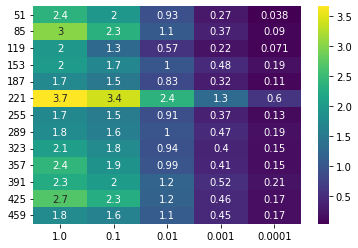

In [24]:
import seaborn as sns
sns.heatmap(variances_diff, cmap='viridis', xticklabels=[round(x, 5) for x in lams], yticklabels=np.unique(ps), annot=True)

In [25]:
# divide each row of largest_eigval_F_div_n by the corresponding

<AxesSubplot: >

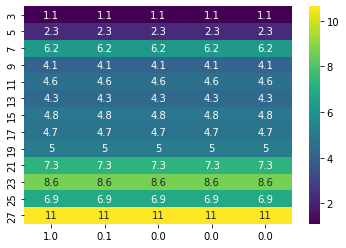

In [26]:
sns.heatmap(largest_eigval_F_div_n, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ns, annot=True)

<AxesSubplot: >

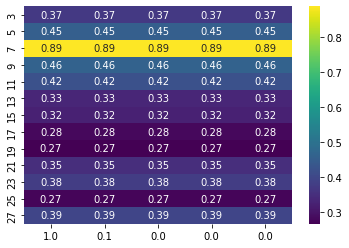

In [27]:
# row of largest_eigval_F_div_n by the corresponding n
new_largest_eigval_F_div_n = np.zeros((n_ns,n_lams))
for i in range(len(ns)):
    new_largest_eigval_F_div_n[i,:] = largest_eigval_F_div_n[i,:] / ns[i]

sns.heatmap(new_largest_eigval_F_div_n, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ns, annot=True)

In [61]:
# TODO: Triple check that we are computing the inverse well now and that we were doing it wrong before. Because the tests were passing before.

In [62]:
c[:3,:3]

array([[7.07106781, 6.36396103, 5.72756493],
       [6.36396103, 7.07106781, 6.36396103],
       [5.72756493, 6.36396103, 7.07106781]])

In [63]:
(c + damping*np.eye(d))[:3,:3]

array([[7.77817459, 6.36396103, 5.72756493],
       [6.36396103, 7.77817459, 6.36396103],
       [5.72756493, 6.36396103, 7.77817459]])

In [64]:
np.linalg.inv(c+ damping*np.eye(d))[:3,:3]

array([[ 0.40672876, -0.26077797, -0.06749992],
       [-0.26077797,  0.573929  , -0.21749976],
       [-0.06749992, -0.21749976,  0.58513116]])

In [18]:
import torch
torch.cholesky_inverse(torch.from_numpy(c+ damping*np.eye(d)))[:3,:3]

tensor([[ 0.0352, -0.0173, -0.0002],
        [-0.0173,  0.0352, -0.0173],
        [-0.0002, -0.0173,  0.0352]], dtype=torch.float64)

In [39]:
import torch
torch.cholesky_inverse(torch.cholesky(torch.from_numpy(c+ damping*np.eye(d))))[:3,:3]

tensor([[ 0.1522, -0.1304, -0.0057],
        [-0.1304,  0.2640, -0.1256],
        [-0.0057, -0.1256,  0.2642]], dtype=torch.float64)

In [40]:
np.linalg.inv(c+ damping*np.eye(d))[:3,:3]

array([[ 0.15224482, -0.13042363, -0.00565121],
       [-0.13042363,  0.26397487, -0.1255824 ],
       [-0.00565121, -0.1255824 ,  0.26418464]])

In [41]:
P_damped[:3,:3]

array([[ 0.15224482, -0.13042363, -0.00565121],
       [-0.13042363,  0.26397487, -0.1255824 ],
       [-0.00565121, -0.1255824 ,  0.26418464]])

In [42]:
F_inv.numpy()[:3,:3]

array([[ 1.73584905e-03, -8.49996340e-04, -8.67206609e-06],
       [-8.49996340e-04,  1.73288370e-03, -8.62042779e-04],
       [-8.67206609e-06, -8.62042779e-04,  1.76788253e-03]])

## Doing Lambda parralel

In [52]:
import matplotlib.pyplot as plt
import numpy as np

N = 10
N_extra = 30000
d = 15
sigma2 = 2
ro = 0.9
n_ns = 5
n_lams = 3
variances_damped = np.zeros((n_ns,n_lams))
variances_ngd = np.zeros((n_ns,n_lams))
variances_diff = np.zeros((n_ns,n_lams))    
largest_eigval_F_div_n = np.zeros((n_ns,n_lams))

ns = [int(x) for x in np.linspace(int(np.sqrt(1.5*N)),int(np.sqrt(6*N)),n_ns)]
ps = []
#lams = np.logspace(0, -5, num=n_lams, endpoint=True, base=10.0)
lams = [1.0, 0.01, 0.0001]
dampings = []

def get_variances(i: int, j: int, n: int, p: int, F_extra: np.ndarray, features: np.ndarray, sigma2: float, e_F_div_n: float, v_ngd: float):
        print(' ')
        print('-'*50)
        lam = lams[j]
        damping = lam * n
        print(f'p = {p}')
        print(f'lambda = {lam}')

        P_damped = np.linalg.inv(F_extra + damping * np.eye(p))

        largest_eigval_F_div_n[i, j] = e_F_div_n
        variances_damped[i, j] = kernel_variance_interpolator(features=features, P=P_damped, F=F_extra, sigma2=sigma2) 
        variances_ngd[i, j] = v_ngd
        variances_diff[i, j] = variances_damped[i, j] - variances_ngd[i, j]

for i in range(n_ns):
    n = ns[i]
    params = {
            'width' : n,
            'depth' : 2,
            'd' : d,
            'lam' : -10000000, # damping does not matter here if we are not using .get_features_and_p_inv()
            'train_size' : N,
            'extra_size' : N_extra,
            'sigma2' : sigma2,
            'r2' : 1,
            'regime' : 'autoregressive',
            'ro' : ro
        }
    ini = Initializer(**params)
    features, F_extra = [x.numpy() for x in ini.get_features_and_F()]
    p = F_extra.shape[0]
    ps.append(p)
    P_ngd = np.linalg.inv(F_extra)

    ### TODO: There is an error here!! this eigenvalue (divided by n) is decreasing with n, but it should be constant.
    ### check if I'm doing the right parametrization!!!
    
    e_F_div_n = np.linalg.eigvalsh(F_extra)[-1]/n
    v_ngd = kernel_variance_interpolator(features=features, P=P_ngd, F=F_extra, sigma2=sigma2)

    threads = []
    for j in range(n_lams):
        t = threading.Thread(target=get_variances, args=(i, j, n, p, F_extra, features, sigma2, e_F_div_n, v_ngd,))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

# choose only unique ps
ps = np.unique(ps)

  
--------------------------------------------------
p = 51
lambda = 1.0

--------------------------------------------------
p = 51
lambda = 0.01
 
--------------------------------------------------
p = 51
lambda = 0.0001
 
--------------------------------------------------
p = 68
lambda = 1.0 

--------------------------------------------------
p = 68
lambda = 0.01
 
--------------------------------------------------
p = 68
lambda = 0.0001
  
--------------------------------------------------
p = 85
lambda = 1.0

--------------------------------------------------
p = 85
lambda = 0.01
 
--------------------------------------------------
p = 85
lambda = 0.0001
  
--------------------------------------------------
p = 102
lambda = 1.0
 
--------------------------------------------------
p = 102
lambda = 0.0001

--------------------------------------------------
p = 102
lambda = 0.01
  
--------------------------------------------------
p = 119
lambda = 1.0
------------------------------